# MiniProject 1: Clustering MNIST with Kohonen Maps

Our goal is to implement the Kohonen algorithm (or self-organizing map) and apply
it to a data set of hand-written digits. The advantage of the data set is that it is easy
to visualize, so that you can easily control the performance of the algorithm by visual
inspection.

In [1]:
import numpy as np
import scipy.spatial.distance as distm
import matplotlib.pylab as plb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy import stats
sns.set()
%matplotlib inline

### 1. Loading MNIST

In [83]:
# load in data and labels    
data = np.array(np.loadtxt('Resources/data.txt'))
labels = np.loadtxt('Resources/labels.txt')

Actually, we are not going to work with the 10 different digits from MNIST, only with 4 of them. They choice of digits is made by provided "name2digits" function that we define below. The name of choice four our experiment is "Dunai Vidit", an aggregation of our two names.

In [84]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('Resources/hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])

In [85]:
 # select 4 digits    
name = 'Dunai Vidit' # REPLACE BY YOUR OWN NAME
targetdigits = name2digits(name) # assign the four digits that should be used
print(targetdigits) # output the digits that were selected

[1 4 5 6]


/Users/vidit/anaconda3/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Next we filter our data by the given digits "1,4,5,6". We also generate a test set so as to predict accuracy of the learnt map on unseen data.

In [86]:
 # this selects all data vectors that corresponds to one of the four digits
data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
labels = labels[np.logical_or.reduce([labels==x for x in targetdigits])]
data, data_test, labels, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)

dy, dx = data.shape

### 2. Defining the functions

First the neighbouring function

In [6]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

For the iterative algorithm

In [7]:
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])

### 3. Learning Rate 

Now we start optimising our parameters, starting with convergence criteria. We consider the mean squared centers update at each iteration as stopping measure. If this value goes down to below a certain tolerance for more than 1000 iterations we stop updating the centers. Different learning values are tested and best is chosen.

In [68]:
def kohonen_eta():
    
    plb.close('all')
    
    
    dim = 28*28
    data_range = 255.0
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    size_k = 6
    
    start = 0 #learning rate = 1
    stop = -3 #learning rate = 0.001
    
    #create a list of learning rate values in logspace
    eta_list = np.logspace(start,stop, 5)
    
    #store the final center position for each learning rate
    final_centers = {}
    
    #loop over the set of learning rate values
    for j, eta in enumerate(eta_list):
        print(eta)

    
        #set the width of the neighborhood via the width of the gaussian that
        #describes it
        sigma = 3.0

        #initialise the centers randomly
        centers = np.random.rand(size_k**2, dim) * data_range

        #build a neighborhood matrix
        neighbor = np.arange(size_k**2).reshape((size_k, size_k))

        #set the maximal iteration count
        tmax = 5000 

        #set the random order in which the datapoints should be presented
        i_random = np.arange(tmax) % dy
        np.random.shuffle(i_random)

        deltacenters = list()
        error = list()
        ini_centers = 0
        
        #center update tolerance value
        tolerance = 800
        #to save number of times tolerance value is achieved
        counter = 0
        
        
        for t, i in enumerate(i_random):
            ini_centers = centers.copy()
            som_step(centers, data[i,:],neighbor,eta,sigma)
            deltacenters.append(np.mean(np.linalg.norm(ini_centers - centers, axis=1)))
            error.append(np.mean(np.linalg.norm(ini_centers - centers, axis=1)))

            if error[t] < tolerance*eta :
                counter += 1
            
            if counter > 100:
                print('Converged at iteration:{}'.format(t))
                break
            
            
            final_centers[j] = centers
           
        if t == tmax:
            print('Did not converge')
        

        fig, ax = plb.subplots(figsize=(20, 10))    
        plb.subplot(len(eta_list),1,j+1)
        plb.title('eta = {}'.format(eta))
        plb.ylabel('Mean Squared Weight Update')
        plb.plot(error)
    
    plb.xlabel('Iterations',fontsize=20)
    plb.tight_layout()
    
    fig.savefig('full_figure.png')
    
    return final_centers



1.0
Converged at iteration:1801
0.177827941004
Converged at iteration:346
0.0316227766017
Converged at iteration:458
0.0056234132519
Converged at iteration:1414
0.001


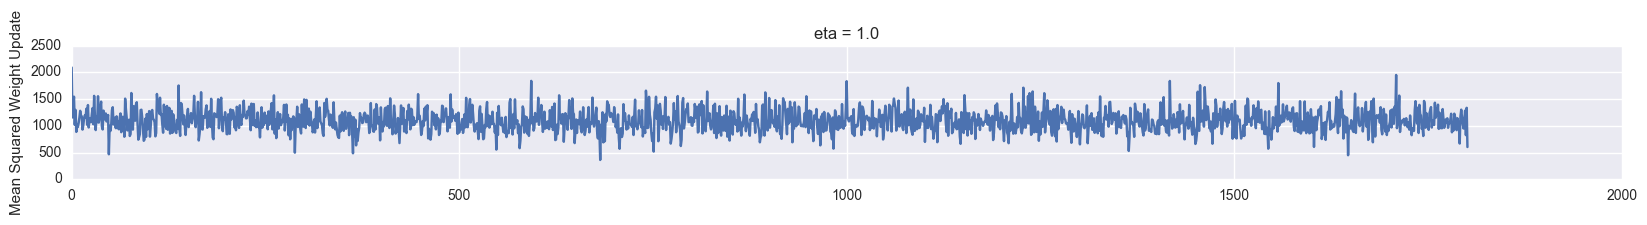

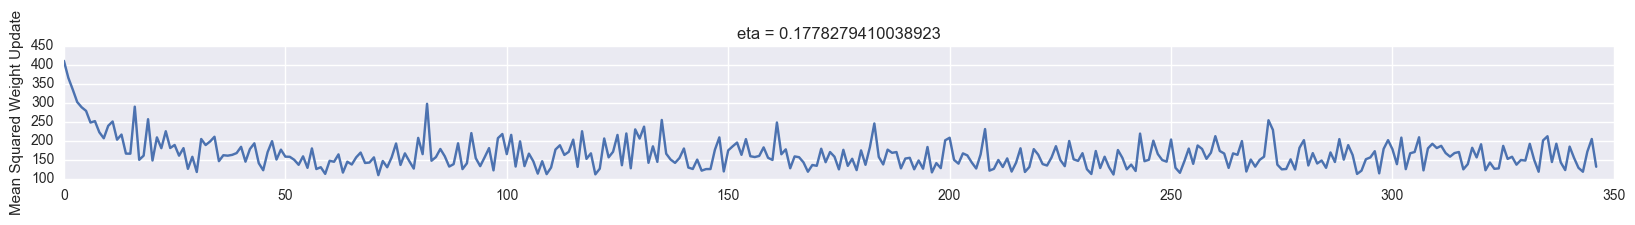

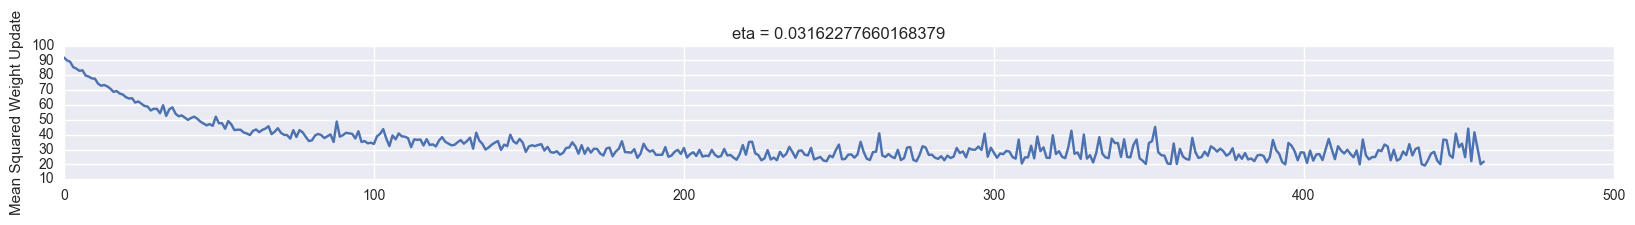

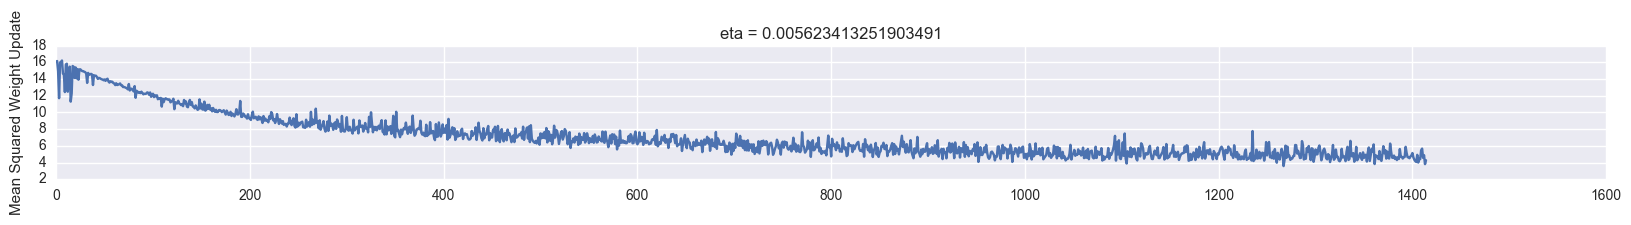

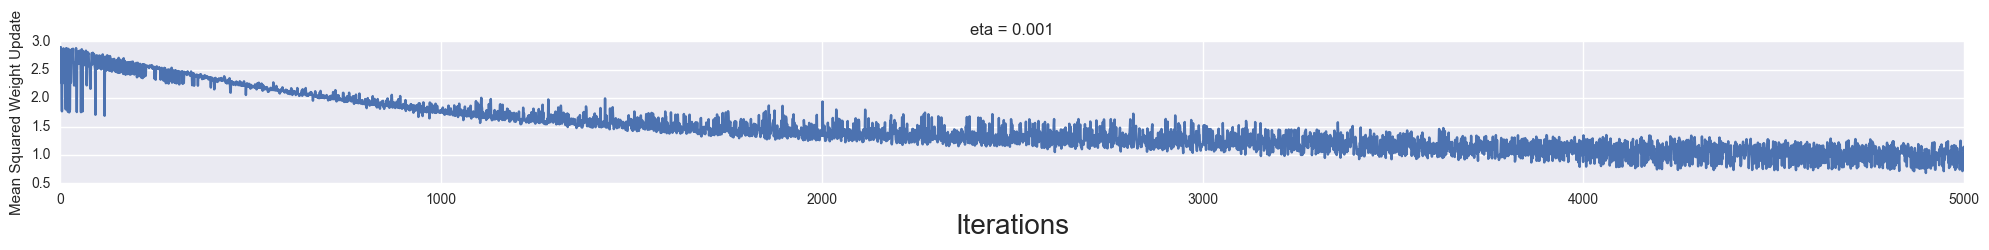

In [70]:
final_centers = kohonen_eta()

From the above figures we see that eta = 0.17 and eta = 0.03 converge faster than other values. We take value in between them i.e. eta = 0.1 henceforth. 

Visualisation of the centers converged to for different eta values. For high learning rate we see that all centers end up together on one cluster because they oscillate a lot. The lower learning rate centers move but as sigma value is high all the centers are more influenced by each other.  

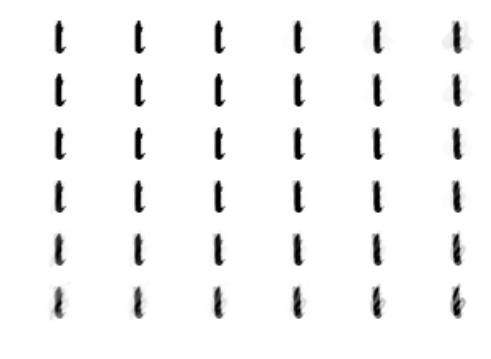

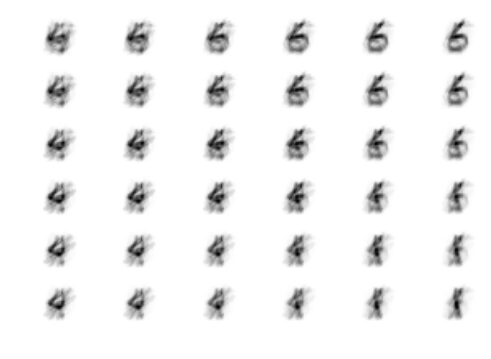

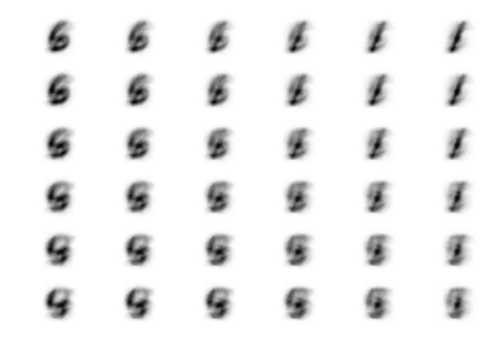

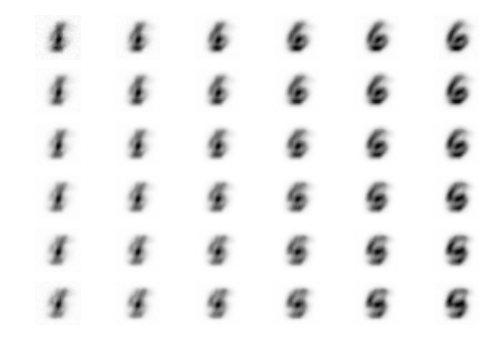

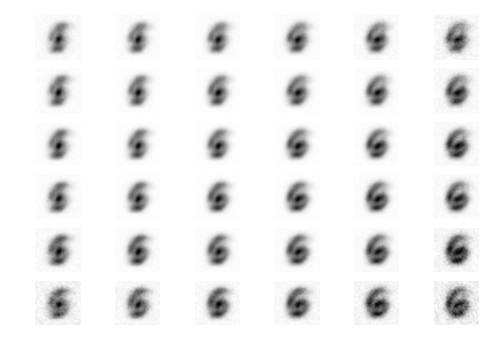

In [72]:
size_k = 6
# for visualization, you can use this:
for centers  in final_centers.values():
    for i in range(size_k**2):
        plb.subplot(size_k,size_k,i+1)

        plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')

    # leave the window open at the end of the loop
    plb.show()
    plb.draw()

### 4. Prototype Labelling
We use KNN method to assign labels to prototype. 

In [82]:
def get_center_labels(centers,neighbours):
    indx_sort = np.argsort(distm.cdist(centers,data),axis=1)
    indx_sort = indx_sort[:,0:neighbours]
    unit_label = stats.mode(labels[indx_sort],axis=1)[0]
    return unit_label.flatten()

K=3 neighbours are used for label assignment and we fix this value to avoid overfitting using smaller number of neighbours. The prototype labels for the above centers obtained for different eta, are shown here.

In [94]:
neighbours = 3
for centers in final_centers.values():
    unit_label = get_center_labels(centers,neighbours)
    print(np.resize(unit_label,(size_k,size_k)))

[[ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]]
[[ 4.  4.  4.  6.  6.  6.]
 [ 4.  4.  4.  6.  6.  6.]
 [ 4.  4.  4.  4.  1.  1.]
 [ 4.  4.  4.  1.  1.  1.]
 [ 4.  4.  4.  1.  1.  1.]
 [ 4.  4.  4.  1.  1.  1.]]
[[ 6.  6.  1.  1.  1.  1.]
 [ 6.  5.  1.  1.  1.  1.]
 [ 4.  5.  1.  1.  1.  1.]
 [ 4.  5.  5.  1.  1.  1.]
 [ 4.  4.  4.  1.  1.  1.]
 [ 4.  4.  4.  4.  1.  1.]]
[[ 1.  1.  1.  6.  6.  6.]
 [ 1.  1.  1.  6.  6.  6.]
 [ 1.  1.  1.  1.  5.  6.]
 [ 1.  1.  1.  1.  5.  5.]
 [ 1.  1.  1.  1.  4.  5.]
 [ 1.  1.  1.  4.  4.  4.]]
[[ 1.  1.  1.  4.  4.  4.]
 [ 1.  1.  1.  1.  4.  4.]
 [ 1.  1.  1.  4.  4.  4.]
 [ 1.  1.  1.  4.  4.  6.]
 [ 1.  1.  5.  4.  6.  6.]
 [ 1.  1.  5.  4.  6.  6.]]


### 5. Grid Search for different sizes of the sigma and units.
The unit sizes and sigma values are varied and fixed value of learning rate eta = 0.1 which is in between the 0.17 and 0.03 (they had better convergence before) 
Here we run for tmax iterations as our convergence criteria doesn't apply to different sigmas (different tolerance values will be required)

In [141]:
def kohonen_grid(l_sigma,l_size):
 
    plb.close('all')
    
    #neighbours considered for KNN prototype labelling
    neighbours = 3 
    
    dim = 28*28
    data_range = 255.0
    
    #set the learning rate
    eta = 0.1 

    #set the maximal iteration count
    tmax = 5000 
    
    final_centers = {}
    index = np.arange(len(l_sigma)*len(l_size)).reshape((len(l_sigma),len(l_size)))
    
    #accuracy of classfication on test data
    mean_accuracy = np.empty([len(l_sigma),len(l_size)])
    
    for ii,sigma in enumerate(l_sigma):
        for jj,size_k in enumerate(l_size):
            print('Running for Sigma[{}]:{} and Unit Size[{}]:{}'.format(ii,sigma,jj,size_k))
            

            #initialise the centers randomly
            centers = np.random.rand(size_k**2, dim) * data_range

            #build a neighborhood matrix
            neighbor = np.arange(size_k**2).reshape((size_k, size_k))


            #set the random order in which the datapoints should be presented
            i_random = np.arange(tmax) % dy
            np.random.shuffle(i_random)
            

            for t, i in enumerate(i_random):
                prev_centers =  centers.copy()
                som_step(centers, data[i,:],neighbor,eta,sigma)
            
            final_centers[index[ii][jj]] = centers
            unit_label = get_center_labels(centers,neighbours)
            labels_pred = unit_label[np.argmin(distm.cdist(data_test,centers),axis=1)]
            mean_accuracy[ii,jj] = accuracy_score(labels_test,labels_pred)
   
    print("Accuracy Values")
    print(mean_accuracy)
    return mean_accuracy,final_centers
    

In [156]:
l_sigma = [0.2,0.3,0.5,1,3,5,9] #sigma
l_size = [6,7,8,9,10] #unit sizes

mean_accuracy, final_centers = kohonen_grid(l_sigma,l_size)

Running for Sigma[0]:0.2 and Unit Size[0]:6
Running for Sigma[0]:0.2 and Unit Size[1]:7
Running for Sigma[0]:0.2 and Unit Size[2]:8
Running for Sigma[0]:0.2 and Unit Size[3]:9
Running for Sigma[0]:0.2 and Unit Size[4]:10
Running for Sigma[1]:0.3 and Unit Size[0]:6
Running for Sigma[1]:0.3 and Unit Size[1]:7
Running for Sigma[1]:0.3 and Unit Size[2]:8
Running for Sigma[1]:0.3 and Unit Size[3]:9
Running for Sigma[1]:0.3 and Unit Size[4]:10
Running for Sigma[2]:0.5 and Unit Size[0]:6
Running for Sigma[2]:0.5 and Unit Size[1]:7
Running for Sigma[2]:0.5 and Unit Size[2]:8
Running for Sigma[2]:0.5 and Unit Size[3]:9
Running for Sigma[2]:0.5 and Unit Size[4]:10
Running for Sigma[3]:1 and Unit Size[0]:6
Running for Sigma[3]:1 and Unit Size[1]:7
Running for Sigma[3]:1 and Unit Size[2]:8
Running for Sigma[3]:1 and Unit Size[3]:9
Running for Sigma[3]:1 and Unit Size[4]:10
Running for Sigma[4]:3 and Unit Size[0]:6
Running for Sigma[4]:3 and Unit Size[1]:7
Running for Sigma[4]:3 and Unit Size[2]:8


The heatmap shows accuracy over test set. As we increase the size of units we tend to overfit, hence lower accuracy. To overcome we need to have larger sigma which acts as a regularisation. Best accuracy = 0.95 is achieved with size = 8 and sigma = 0.5

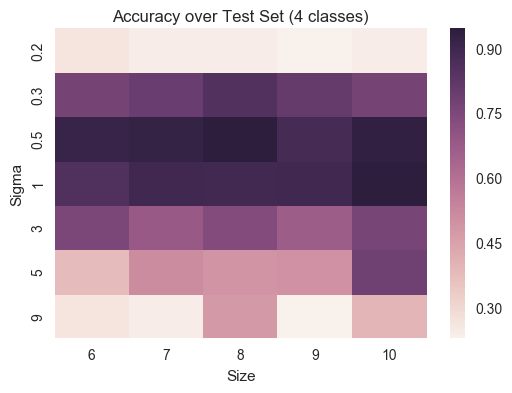

In [162]:
ax = sns.heatmap(mean_accuracy,xticklabels=l_size,yticklabels=l_sigma)
ax.set_ylabel('Sigma')
ax.set_xlabel('Size')
ax.set_title('Accuracy over Test Set (4 classes)')

### 6.  Sigma Decay
Now using the best unit size  = 8 and learning rate = 0.05, we decay the learning rate linearly with the iterations. 

In [248]:
def kohonen_decay():

    plb.close('all')
    
    
    dim = 28*28
    data_range = 255.0
     

    #initial sigma value
    sigma0 = 5

    #the learning rate
    eta = 0.05 

    #set the maximal iteration count
    tmax = 5000 # this might or might not work; use your own convergence criterion


    #best size of the Kohonen map. 
    size_k = 8

    #neighbours of KNN
    neighbours =3
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    

    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))


    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)

    #accuracy with iterations
    acc = []
    sigmas = []
    for t, i in enumerate(i_random):
        sigma = sigma0-t*(sigma0/tmax)
        som_step(centers, data[i,:],neighbor,eta,sigma)
        
        if t%100 == 0:
            print("Running for sigma: {}".format(sigma))
            unit_label_ = get_center_labels(centers,neighbours)
            labels_pred = unit_label_[np.argmin(distm.cdist(data_test,centers),axis=1)]
            acc.append(accuracy_score(labels_test,labels_pred)) 
            sigmas.append(sigma)

    plb.plot(sigmas,acc)
    plb.xlim(np.max(sigmas), 0)
    plb.xlabel('Sigma value with iterations')
    plb.ylabel('Accuracy')
    plb.title('Accuracy with Sigma Decay')
    plb.grid(True)
    return centers
   

The accuracy value with sigma decay in each iteration. We see that accuracy improves with iterations.

Running for sigma: 5.0
Running for sigma: 4.9
Running for sigma: 4.8
Running for sigma: 4.7
Running for sigma: 4.6
Running for sigma: 4.5
Running for sigma: 4.4
Running for sigma: 4.3
Running for sigma: 4.2
Running for sigma: 4.1
Running for sigma: 4.0
Running for sigma: 3.9
Running for sigma: 3.8
Running for sigma: 3.7
Running for sigma: 3.5999999999999996
Running for sigma: 3.5
Running for sigma: 3.4
Running for sigma: 3.3
Running for sigma: 3.2
Running for sigma: 3.0999999999999996
Running for sigma: 3.0
Running for sigma: 2.9
Running for sigma: 2.8
Running for sigma: 2.6999999999999997
Running for sigma: 2.6
Running for sigma: 2.5
Running for sigma: 2.4
Running for sigma: 2.3
Running for sigma: 2.1999999999999997
Running for sigma: 2.1
Running for sigma: 2.0
Running for sigma: 1.9
Running for sigma: 1.7999999999999998
Running for sigma: 1.6999999999999997
Running for sigma: 1.6
Running for sigma: 1.5
Running for sigma: 1.4
Running for sigma: 1.2999999999999998
Running for sigma: 1.

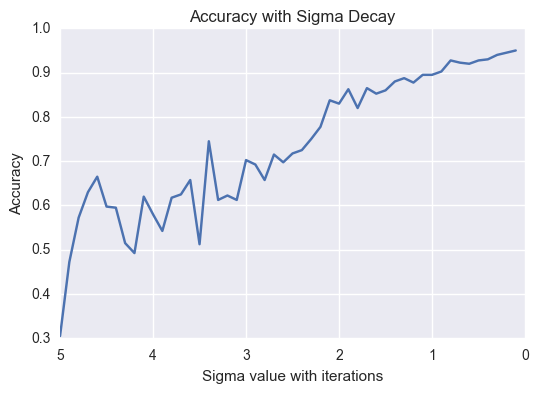

In [249]:
centers = kohonen_decay()

The final accuracy improves a bit with this method.


Prototype Labels
[[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 5.  1.  6.  6.  6.  5.  5.  4.]
 [ 5.  5.  6.  6.  6.  4.  4.  4.]
 [ 5.  5.  6.  6.  6.  4.  4.  4.]
 [ 5.  5.  6.  6.  6.  4.  4.  4.]
 [ 5.  5.  6.  6.  6.  4.  4.  4.]
 [ 5.  5.  6.  6.  6.  6.  4.  4.]]


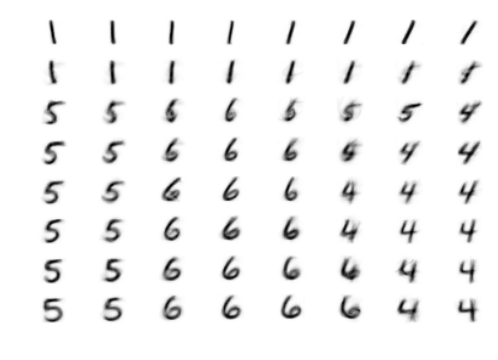

Mean Accuracy 0.955


In [250]:
unit_label = get_center_labels(centers,neighbours)
size_k = 8
print("\nPrototype Labels")
print(np.resize(unit_label,(size_k,size_k)))

# for visualization, you can use this:
for i in range(size_k**2):
    plb.subplot(size_k,size_k,i+1)
    plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
    plb.axis('off')

# leave the window open at the end of the loop
plb.show()
plb.draw()


labels_pred = unit_label[np.argmin(distm.cdist(data_test,centers),axis=1)]
mean_accuracy = accuracy_score(labels_test,labels_pred)
print("Mean Accuracy {}".format(mean_accuracy))